In [204]:
import pandas as pd
import numpy as np
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as skp
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [184]:
#leemos el archivo .json y las transponemos
train = pd.read_json('data/train_products.json').T
test = pd.read_json('data/test_products.json').T

In [185]:
train.head()

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère",unknown,"[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",1,unknown,...,b,[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour",unknown,"[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...",10,unknown,...,e,"[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,Cini Minis,"Nestlé, Nestlé",,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...",3,0.635,...,d,"[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,Cuor di fette Carrefour,Carrefour,unknown,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",2,unknown,...,e,[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,Curry,"Carrefour,Groupe Carrefour",unknown,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....",0,unknown,...,unknown,"[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [186]:
train.columns

Index(['name', 'brand', 'generic_name', 'categories_hierarchy', 'is_beverage',
       'selling_countries', 'ingredient_origins', 'ingredients',
       'additives_count', 'calcium_100g', 'carbohydrates_100g',
       'energy_kcal_100g', 'fat_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'sugars_100g', 'nutrition_grade',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade'],
      dtype='object')

In [187]:
#eliminamos las columnas que no tiene informacion relevante
# respecto a la variable respuesta
columns_drop = ['name', 'brand', 'generic_name', 'categories_hierarchy',
                'selling_countries', 'ingredient_origins', 'ingredients',
                'additives_count']

train_drop = train.drop(columns_drop, axis=1)
test_drop = test.drop(columns_drop, axis=1)

train_drop.head()

,is_beverage,calcium_100g,carbohydrates_100g,energy_kcal_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,0,unknown,21,unknown,7.1,2.2,2.2,0.7,0.28,0.5,b,[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,0,unknown,58,366,14,unknown,2.9,0.3,0.12,37,e,"[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,0,0.635,73.8,423,10.3,5,6.2,0.9,0.36,25,d,"[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,0,unknown,8.5,unknown,19,0,15,2.5,1,8.5,e,[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,0,unknown,0,0,0,0,0,0,0,0,unknown,"[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


Vamos a transformar la variable packaging_materials para que valga un 1 si hay plastico y 0 si no hay plastico

In [188]:
#transforma la variable packaging_material en una variable dummy
def contains_plastic(list_material):
    '''Función que '''
    if 'plastic' in list_material[0]:
        return 1
    else:
        return 0
    
train_drop['packaging_materials'] = train_drop['packaging_materials'].apply(contains_plastic)
test_drop['packaging_materials'] = test_drop['packaging_materials'].apply(contains_plastic)
train_drop.head()

,is_beverage,calcium_100g,carbohydrates_100g,energy_kcal_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,0,unknown,21,unknown,7.1,2.2,2.2,0.7,0.28,0.5,b,1,1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,0,unknown,58,366,14,unknown,2.9,0.3,0.12,37,e,0,1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,0,0.635,73.8,423,10.3,5,6.2,0.9,0.36,25,d,0,1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,0,unknown,8.5,unknown,19,0,15,2.5,1,8.5,e,1,1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,0,unknown,0,0,0,0,0,0,0,0,unknown,0,0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [189]:
#a los producto que no tienen informacion de nutriton_grade se les asigna una c
train_drop['nutrition_grade'] = train_drop['nutrition_grade'].apply(lambda x: 'c' if x == 'unknown' else x)
test_drop['nutrition_grade'] = test_drop['nutrition_grade'].apply(lambda x: 'c' if x == 'unknown' else x)

#eliminamos la variable calcium_100g por tener muchos valores nulos
train_drop = train_drop.drop('calcium_100g', axis=1)
test_drop = test_drop.drop('calcium_100g', axis=1)

def imputar_mean(df, variable):
    '''Función que imputa la media de una variable a los valores nulos'''
    #primero reemplazamos los valores unknown por np.nan
    df[variable] = df[variable].apply(lambda x: np.nan if x == 'unknown' else x).astype(float)
    mean = df[variable].mean()
    df[variable] = df[variable].fillna(mean)

imputar_mean(train_drop, 'carbohydrates_100g')
imputar_mean(train_drop, 'energy_kcal_100g')
imputar_mean(train_drop, 'fat_100g')
imputar_mean(train_drop, 'fiber_100g')
imputar_mean(train_drop, 'proteins_100g')
imputar_mean(train_drop, 'salt_100g')
imputar_mean(train_drop, 'sodium_100g')
imputar_mean(train_drop, 'sugars_100g')

imputar_mean(test_drop, 'carbohydrates_100g')
imputar_mean(test_drop, 'energy_kcal_100g')
imputar_mean(test_drop, 'fat_100g')
imputar_mean(test_drop, 'fiber_100g')
imputar_mean(test_drop, 'proteins_100g')
imputar_mean(test_drop, 'salt_100g')
imputar_mean(test_drop, 'sodium_100g')
imputar_mean(test_drop, 'sugars_100g')


In [190]:
train_drop.head()

,is_beverage,carbohydrates_100g,energy_kcal_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,0,21.0,270.01574,7.1,2.200000,2.2,0.7,0.28,0.5,b,1,1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,0,58.0,366.00000,14.0,2.809586,2.9,0.3,0.12,37.0,e,0,1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,0,73.8,423.00000,10.3,5.000000,6.2,0.9,0.36,25.0,d,0,1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,0,8.5,270.01574,19.0,0.000000,15.0,2.5,1.00,8.5,e,1,1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00,0.0,c,0,0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [191]:
#finalmente pasamos la variable nutrition_grade a numerica
train_drop['nutrition_grade'] = train_drop['nutrition_grade'].apply(lambda x: ord(x) - 97)
test_drop['nutrition_grade'] = test_drop['nutrition_grade'].apply(lambda x: ord(x) - 97)

In [192]:
#separamos entre variables explicativas y variable respuesta
X = train_drop.drop('nutrition_grade', axis=1)
y = train_drop['nutrition_grade']

#separamos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 2001, test_size = 0.2)

In [193]:
#creamos una red con tf
import tensorflow as tf
from tensorflow import keras

In [210]:
#pasamos a tensores
X_train_tensor = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test.values, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

#noramlizamos los datos
X_train_tensor = tf.keras.utils.normalize(X_train_tensor, axis=1)
X_test_tensor = tf.keras.utils.normalize(X_test_tensor, axis=1)

In [203]:
#creamos el modelo y agragamos dropout
model = keras.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=[len(X_train.keys())]),
    # keras.layers.Dropout(0.1),
    # keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    # keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    # keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    # keras.layers.Dropout(0.1),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

#visualizamos el modelo
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 1024)              19456     
                                                                 
 dense_122 (Dense)           (None, 512)               524800    
                                                                 
 dense_123 (Dense)           (None, 512)               262656    
                                                                 
 dense_124 (Dense)           (None, 512)               262656    
                                                                 
 dense_125 (Dense)           (None, 256)               131328    
                                                                 
 dense_126 (Dense)           (None, 128)               32896     
                                                                 
 dense_127 (Dense)           (None, 64)              

Epoch 1/600
261/261 [==============================] - 4s 15ms/step - loss: 0.2591 - accuracy: 0.9035 - val_loss: 0.9012 - val_accuracy: 0.7955
Epoch 2/600
261/261 [==============================] - 4s 14ms/step - loss: 0.2575 - accuracy: 0.9053 - val_loss: 0.8973 - val_accuracy: 0.7943
Epoch 3/600
261/261 [==============================] - 4s 14ms/step - loss: 0.2592 - accuracy: 0.9016 - val_loss: 0.8958 - val_accuracy: 0.7924
Epoch 4/600
261/261 [==============================] - 4s 14ms/step - loss: 0.2588 - accuracy: 0.9009 - val_loss: 0.8971 - val_accuracy: 0.7941
Epoch 5/600
261/261 [==============================] - 4s 14ms/step - loss: 0.2586 - accuracy: 0.9011 - val_loss: 0.9179 - val_accuracy: 0.7943
Epoch 6/600
261/261 [==============================] - 4s 16ms/step - loss: 0.2577 - accuracy: 0.9027 - val_loss: 0.9068 - val_accuracy: 0.7967
Epoch 7/600
261/261 [==============================] - 4s 14ms/step - loss: 0.2588 - accuracy: 0.9026 - val_loss: 0.9070 - val_accuracy:

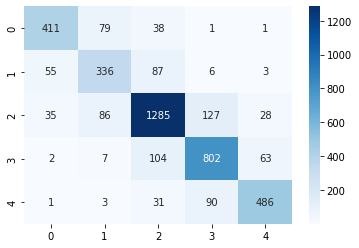

In [233]:
#compilamos el modelo con adam
optimizer = keras.optimizers.Adam(learning_rate = 0.00001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

#entrenamos el modelo y validamos con X_test y y_test y bat size de 32
history = model.fit(X_train_tensor, y_train_tensor, epochs = 600, validation_data = (X_test_tensor, y_test_tensor), batch_size = 64)

#graficamos la matriz de confusion
y_pred = model.predict(X_test_tensor)
y_pred = np.argmax(y_pred, axis=1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

#guardamos el modelo
model.save('modelos/modelo_1.h5')

In [234]:
#hacemos las predicciones para el test
X_test_final_tensor = tf.convert_to_tensor(test_drop.values, dtype=tf.float32)
X_test_final_tensor = tf.keras.utils.normalize(X_test_final_tensor, axis=1)

y_pred_final = model.predict(X_test_final_tensor)
y_pred_final = np.argmax(y_pred_final, axis=1)

#guardamos las predicciones
dic_pred = {str(i) : y_pred_final[i] for i in range(len(y_pred_final))}
dic_pred = {'target': dic_pred}
df_pred = pd.DataFrame(dic_pred)
df_pred.to_json('data/prediction.json')

In [237]:
#creamos una maquina de soporte vectorial con grid search 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#definimos los parametros
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf', 'poly', 'sigmoid']
                }
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

#entrenamos
grid.fit(X_train, y_train)

#hacemos predicciones
y_pred = grid.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')



Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.377 total time=  27.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.378 total time=  27.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.377 total time=  27.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.378 total time=  27.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.378 total time=  27.3s
